Using the seed 4005883164


  0%|          | 0/20 [00:00<?, ?it/s]

(the land of the frogs, deformalism, painted by zdzislaw beksinski:1), (a beautiful red-violet landscape:0.5)


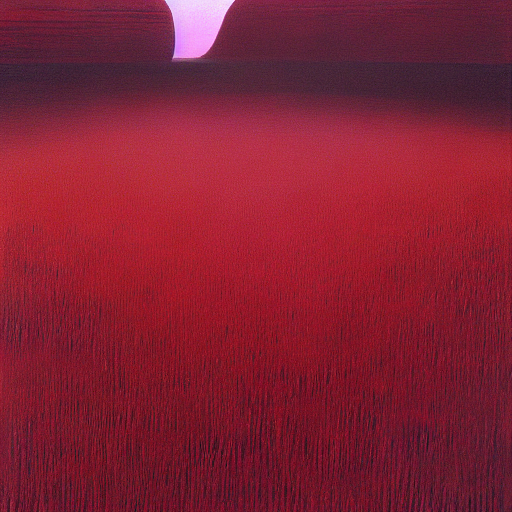

In [3]:
# Installation

# If you know what you're doing and want to connect this cell to Google Drive, 
# uncomment the two below lines:

# from google.colab import drive
# drive.mount('/content/gdrive')

# and then uncomment the following lines depending on if you want to save outputs to 
# your google drive, use custom text embedding files or use custom text files for
# random lists

# outputs_folder = "/content/gdrive/MyDrive/AI/StableDiffusion" #@param{type: 'string'}
# custom_embeddings_folder = "/content/gdrive/MyDrive/AI/StableDiffusion/embeddings" #@param{type: 'string'}
# custom_randomizer_folder = "/content/gdrive/MyDrive/AI/StableDiffusion/randomizers" #@param{type: 'string'}

# For loading custom models from google drive, first set the below variable to True
load_custom_model = False
# then enter the filepath to the custom model below
# The filepath should have letters, numbers and/or dashes ( - ), the function doesn't like underscores ( _ )
custom_model_path = ""
# To switch back to the preset models, set "load_custom_model" back to False

#@markdown
model = "Stable Diffusion 1.5" #@param ["Stable Diffusion 1.5", "Stable Diffusion 2.1 (512)", "Stable Diffusion 2.1 (768)", "Mitsua Diffusion One", "Dreamlike Diffusion", "Openjourney V2 Beta", "seek.art_MEGA 2.0", "Analog Diffusion", "Dreamlike Photoreal", "Foto Assisted Diffusion (FAD)_V0 ", "Anything v3.0", "Anything v4.0", "AbyssOrangeMix3", "Dreamlike Anime", "Waifu Diffusion 1.3", "Waifu Diffusion 1.4", "Waifu Diffusion 1.5 Beta (768)", "Plat Diffusion (Waifu 1.4 finetune)", "Pastel Waifu Diffusion", "Collage Diffusion", "Coloring Book (768)", "Graphic Art (768)", "Inkpunk Diffusion", "Pulp Diffusion (768)", "Vector Art (768)", "Vivid Watercolors", "Gigafractal Diffusion (768)", "Tensorfunk", "Van Gogh Diffusion", "Modern Art Style", "Corporate Memphis", "Pokemon Diffusion", "Robo Diffusion", "Classic Animation Diffusion", "Modern Animation Diffusion", "Ghibli Diffusion", "Furry Diffusion", "Pony Diffusion"] {type:"string"}


download_a_collection_of_text_inversion_embeddings_and_load_them = False #@param {type: "boolean"}
display_preprocessed_images = True
display_image_output = True

#@markdown ### <b>Image Generation</b><br>
#@markdown See previous cell for setting explanations
prompt = "(the land of the frogs, \u003C_style>, painted by zdzislaw beksinski:1), (a beautiful \u003C_color> landscape:0.5), ghibli style" #@param{type:"string"}

negative = "frogs" #@param{type: 'string'}
add_automatic_keyword_to_prompt = True #@param {type: "boolean"}
resolution = "Landscape 768x512" #@param ["Custom (Select this and put width and height below)", "Square 512x512 (default, good for most models)", "Landscape 768x512", "Portrait 512x768", "Square 768x768 (good for 768 models)", "Landscape 1152x768 (does not work on free colab)", "Portrait 768x1152 (does not work on free colab)"] {type:"string"}

#width_height = [768,512] #@param{type: 'raw'}
#@markdown <br>
#@markdown <b>Advanced Settings</b>
width_height_if_custom_is_selected = [768, 512] #@param{type: 'raw'}
steps = 20 #@param {type:"integer"}
samples_per_batch = 1
number_of_images = 1 #@param {type:"integer"}
seed = -1 #@param {type:"integer"}
sampler = "UniPC" #@param ["Euler a", "Euler", "KLMS", "DPMSolver++ (2S) (has issues with img2img)", "DPMSolver++ (2M)", "UniPC"] {type:"string"}
guidance_scale = 7 #@param {type:"slider", min:0, max:20, step:0.5}
ddim_eta = 0.0
tiling = False #@param {type: "boolean"}
#@markdown If `tiling` results look poor, double the amount of steps from non-tiling.
#@markdown <br>
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>img2img</b><br>
init_image = "" #@param {type:"string"}
img2img_strength = 0.5 #@param {type:"slider", min:0.1, max:1.0, step:0.05}
#@markdown Lower img2img strength means the image is changed less, while higher img2img strength means the image is changed more
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>controlnet</b><br>

controlnet_model_1 = "scribble (preprocessed/fakescribble)" #@param ["none", "canny", "depth", "openpose",  "openpose with hands and face", "scribble (black lines on white background)", "scribble (preprocessed/fakescribble)", "softedge",  "lineart (black lines on white background)", "lineart (preprocessed/realistic)", "lineart (preprocessed/coarse)", "anime lineart (black lines on white background) (1.x only)", "anime lineart (preprocessed) (1.x only)", "shuffle (1.x only)", "aesthetic (2.x only)", "color (2.x only)" ] {type:"string"}
controlnet_strength_1 = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
controlnet_image_1 = "https://cdn.discordapp.com/attachments/1035001076409172109/1104360534108799126/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg" #@param {type:"string"}
controlnet_image_1_preprocess = True #@param {type: "boolean"}

controlnet_model_2 = "none" #@param ["none", "canny", "depth", "openpose",  "openpose with hands and face", "scribble (black lines on white background)", "scribble (preprocessed)", "softedge",  "lineart (black lines on white background)", "lineart (preprocessed)", "anime lineart (black lines on white background) (1.x only)", "anime lineart (preprocessed) (1.x only)", "shuffle (1.x only)", "aesthetic (2.x only)", "color (2.x only)" ] {type:"string"}
controlnet_strength_2 = 1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
controlnet_image_2 = "https://cdn.discordapp.com/attachments/1035001076409172109/1104360534108799126/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg" #@param {type:"string"}
controlnet_image_2_preprocess = True #@param {type: "boolean"}

#@markdown
#@markdown ---

upscale_results = False #@param {type: 'boolean'}
# detailing = 1 #@param {type:"slider", min:1, max:4, step:1}
upscale_strength = 0.3 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

#@markdown

# Loading and Setup

should_load_downloaded_embeds = False
test_mode = False
enable_attention_slicing = False
enable_xformers = False
enable_gpu_offload = False
on_colab = True
%env PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128

try:
  import torch
  from IPython.display import clear_output
  import src
  %cd /content/simplest-stable/
except ImportError as e:
  print("Above error is intentional, don't worry")
  print("Installing libraries...")
  import os, subprocess
  %cd /content/
  subprocess.run(["git", "clone", "https://github.com/cadaeix/simplest-stable.git"])
  %cd /content/simplest-stable/
  subprocess.run(["git", "checkout", "test-branch"])
  subprocess.run(['pip', 'install', 'git+https://github.com/huggingface/accelerate.git'])
  if enable_xformers:
    subprocess.run(['pip', 'install', 'triton', 'xformers'])
  if on_colab:
    !pip install diffusers==0.14.0 git+https://github.com/huggingface/accelerate.git transformers==4.26.1 scipy==1.10.0 omegaconf==2.3.0 pillow==9.4.0 tqdm==4.64.1 requests==2.28.2 huggingface_hub==0.11.1 ipywidgets==8.0.4 lark==1.1.5 safetensors==0.3.0 clean-fid resize-right pytorch_lightning==1.7.7 torchsde controlnet_aux==0.0.3
    clear_output(wait=False)
  else:
    subprocess.run(["pip3", "install", "-r", "requirements.txt"])
  downloaded_embeds_path = None


import ipywidgets
import importlib
from io import BytesIO
import os, subprocess, sys, json, logging, requests
logging.disable(sys.maxsize)

# Pillow occasionally has odd import errors
from src.import_patch import patch_import_errors
patch_import_errors()

import torch
from datetime import datetime
from PIL import Image
from src.loading import prepare_pipe_from_presets, prepare_pipe_from_filepath, download_a_list_of_embeddings, load_embeddings
from src.process import process_and_generate
from src.utils import free_ram, load_img, invert_controlnet_preprocess, color_controlnet_preprocess
from src.randomizer import get_default_random_lists_from_folder, get_random_lists_from_folder
from IPython.display import clear_output
from diffusers import ControlNetModel
sys.path.append(".")

if download_a_collection_of_text_inversion_embeddings_and_load_them:
  downloaded_embeds_path = "/content/embeds/"
  if not os.path.exists(downloaded_embeds_path):
    subprocess.run(["mkdir", "-p", downloaded_embeds_path])
    with open('src/resources/embeddings_links.json') as embeddingfile:
      embed_dict = json.load(embeddingfile)
    download_a_list_of_embeddings(downloaded_embeds_path, embed_dict["embeddings"])
  should_load_downloaded_embeds = True

try:
  outputs_folder
  if not os.path.exists(outputs_folder):
      os.mkdir(outputs_folder)
  session_folder = outputs_folder
except NameError as e:
  outputs_path = "images/"
  if not os.path.exists(outputs_path):
      os.mkdir(outputs_path)

  print(f"Outputs will be saved to {outputs_path}.")
  session_folder = os.path.join(outputs_path, datetime.now().strftime("%Y_%m_%d"))
  if not os.path.exists(session_folder):
      os.mkdir(session_folder)

try:
  custom_embeddings_folder
  embeddings_path = custom_embeddings_folder if os.path.exists(custom_embeddings_folder) else None
except NameError as e:
  embeddings_path = None

default_randomizers = get_default_random_lists_from_folder(
    "src/resources/randomizers")

try: 
  custom_randomizer_folder
  if os.path.exists(custom_randomizer_folder):
    randomizers = get_random_lists_from_folder(custom_randomizer_folder)
    randomizers = {**default_randomizers, **randomizers}
  else:
    randomizers = default_randomizers
except NameError as e:
  randomizers = default_randomizers

try:
  model_dict
except NameError as e:
  with open('src/resources/models.json') as modelfile:
      model_dict = json.load(modelfile)
  del modelfile

try:
  control_dict
except NameError as e:
    with open('src/resources/controlnet.json') as controlfile:
        control_dict = json.load(controlfile)
    del controlfile

res_dict = {"Square 512x512 (default, good for most models)": [512,512],
            "Landscape 768x512": [768,512],
            "Portrait 512x768": [512,768],
            "Square 768x768 (good for 768 models)": [768,768],
            "Landscape 1152x768 (does not work on free colab)": [1152,768],
            "Portrait 768x1152 (does not work on free colab)":[768,1152]}
width, height = width_height_if_custom_is_selected if resolution == "Custom (Select this and put width and height below)" else res_dict[resolution]

recreate = False
controlnet_recreate = False
try:
  pipe
  if load_custom_model:
    recreate = model_name != custom_model_path
  else:
    recreate = model_name != model
  if recreate:
    del pipe
    free_ram()
except NameError as e:
  pipe = None
  recreate = True

try:
  controlnet_1
  controlnet_recreate_1 = (controlnet_model_1 not in current_controlnet_1) or (controlnet_1 is not None)
  if recreate or controlnet_recreate_1 or controlnet_model_1 == "none":
      del controlnet_1
      free_ram()
      controlnet_1 = None
except NameError as e:
  controlnet_1 = None
  controlnet_recreate_1 = controlnet_model_1 != "none"  

try:
  controlnet_2
  controlnet_recreate_2 = (controlnet_model_2 not in current_controlnet_2) or (controlnet_2 is not None)
  if recreate or controlnet_recreate_2 or controlnet_model_2 == "none":
      del controlnet_2
      free_ram()
      controlnet_2 = None
except NameError as e:
  controlnet_2 = None
  controlnet_recreate_2 = controlnet_model_2 != "none"  

if recreate:
  try:
    if load_custom_model:
      if os.path.exists(custom_model_path):
        print(f"Loading model from filepath {custom_model_path}")
        pipe, pipe_info = prepare_pipe_from_filepath(
          filepath = custom_model_path,
          enable_attention_slicing = enable_attention_slicing,
          enable_xformers = enable_xformers,
          to_cuda = True
        )
        model_name = custom_model_path
      else:
        print("Couldn't validate custom model filepath, sorry.")
        raise Exception("Couldn't access custom model from given filepath")
    else:
      print(f"Loading model: {model}")
      pipe, pipe_info = prepare_pipe_from_presets(
        model_choice = model_dict[model],
        enable_attention_slicing = enable_attention_slicing,
        enable_xformers = enable_xformers,
        to_cuda = True
      )
      model_name = model
    if enable_gpu_offload:
        pipe.enable_model_cpu_offload()
    if should_load_downloaded_embeds:
      pipe = load_embeddings(downloaded_embeds_path, pipe)
    if embeddings_path:
      pipe = load_embeddings(embeddings_path, pipe)
  except Exception as e:
    print(f"Failed to load selected model for some reason, please try loading another model. If that doesn't work, go to Runtime -> Disconnect and Delete Runtime and then rerun this cell, and then if that fails, tell @cadaeic about the following information: Error while trying to load pipe \n Model: {model} \n Custom Model? {load_custom_model} {custom_model_path} \n Attention Slicing? {enable_attention_slicing}, xformers? {enable_xformers}, gpu_offload? {enable_gpu_offload} \n Loading downloaded embeddings? {download_a_collection_of_text_inversion_embeddings_and_load_them} {should_load_downloaded_embeds}\n Error Message: {e}")
    raise e

opt = {
    "model_name" : model,
    "eta" : 0.0,
    "steps" : steps,
    "init_img" : init_image if init_image != "" else None,
    "mask_image": None,
    "number_of_images": number_of_images,
    "prompt" : prompt,
    "negative" : negative,
    "sampler" : sampler,
    "tiling" : tiling,
    "scale" : guidance_scale,
    "seed" : seed,
    "strength" : img2img_strength if init_image != "" else None, # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
    "H" : height - height % 64,
    "W" : width - width % 64,
    #upscale stuff
    "passes" : 1,
    "upscale": upscale_results,
    "upscale_strength" : upscale_strength,
    "detail_scale" : 10,
    "add_keyword": add_automatic_keyword_to_prompt,
    "prediction_type": pipe_info["prediction_type"],
    "keyword": pipe_info.get("keyword"),
    "negative_keyword": pipe_info.get("negative_keyword"),
    "outputs_folder": session_folder,
    "program_version": "Simple Stable 2.0 With ControlNet (Notebook, pre-release 20230522)"
    }

controlnet_1_loaded = False
if controlnet_model_1 != "none" and controlnet_image_1 != "":
  controlnet_1_choice = None
  if control_dict[controlnet_model_1].get(pipe_info["prediction_type"]):
    print("Loading controlnet model...")
    controlnet_1_choice = control_dict[controlnet_model_1].get(pipe_info["prediction_type"])
  elif control_dict[controlnet_model_1].get("fallback"):
    print(f'ControlNet model not compatible with current model, using fallback model...')
    controlnet_1_choice = control_dict[control_dict[controlnet_model_1].get("fallback")].get(pipe_info["prediction_type"])
  
  if controlnet_1_choice:
    try:
      if controlnet_image_1.startswith("http"):
        response = requests.get(controlnet_image_1)
        controlnet_image_input_1 = Image.open(BytesIO(response.content)).convert("RGB").resize((opt["W"], opt["H"]))
      else:
        controlnet_image_input_1 = Image.open(controlnet_image_1).convert("RGB").resize((opt["W"], opt["H"]))
      if controlnet_image_1_preprocess:
        print("Preprocessed Image 1:")
        if "preprocessor" in controlnet_1_choice:
          library = importlib.import_module("controlnet_aux")
          preprocessor = getattr(library, controlnet_1_choice["preprocessor"])

          if "preprocessor_from_pretrained" in controlnet_1_choice:
            preprocessor = preprocessor.from_pretrained("lllyasviel/Annotators")
          else:
            preprocessor = preprocessor()
          
          if "additional_kwargs" in controlnet_1_choice:
            controlnet_image_input_1 = preprocessor(controlnet_image_input_1, **controlnet_1_choice["additional_kwargs"])
          else:
            controlnet_image_input_1 = preprocessor(controlnet_image_input_1)
        elif "other_preprocessor" in controlnet_1_choice:
          if controlnet_1_choice["other_preprocessor"] == "invert":
            controlnet_image_input_1 = invert_controlnet_preprocess(controlnet_image_input_1)
          elif controlnet_1_choice["other_preprocessor"] == "color":
            controlnet_image_input_1 = color_controlnet_preprocess(controlnet_image_input_1)
    except Exception as e:
      print(f"Sorry, couldn't parse the first controlnet image, proceeding without controlnet one... {e}")
      controlnet_image_input_1 = None
    
    if controlnet_image_input_1:
      if controlnet_recreate_1:
        print(controlnet_1_choice["url"])
        controlnet_1 = ControlNetModel.from_pretrained(controlnet_1_choice["url"], torch_dtype=torch.float16)
        controlnet_1.to("cuda")
      current_controlnet_1 = f"{controlnet_model_1}+{model_name}"
      controlnet_1_loaded = True
      if display_preprocessed_images:
        display(controlnet_image_input_1)
  else:
    print("First controlnet not compatible with current model, trying without controlnet one...")

controlnet_2_loaded = False
if controlnet_model_2 != "none" and controlnet_image_2 != "":
  controlnet_2_choice = None
  if control_dict[controlnet_model_2].get(pipe_info["prediction_type"]):
    print("Loading controlnet model...")
    controlnet_2_choice = control_dict[controlnet_model_2].get(pipe_info["prediction_type"])
  elif control_dict[controlnet_model_2].get("fallback"):
    print(f'ControlNet model not compatible with current model, using fallback model...')
    controlnet_2_choice = control_dict[control_dict[controlnet_model_2].get("fallback")].get(pipe_info["prediction_type"])
  
  if controlnet_2_choice:
    try:
      if controlnet_image_2.startswith("http"):
        response = requests.get(controlnet_image_2)
        controlnet_image_input_2 = Image.open(BytesIO(response.content)).convert("RGB").resize((opt["W"], opt["H"]))
      else:
        controlnet_image_input_2 = Image.open(controlnet_image_2).convert("RGB").resize((opt["W"], opt["H"]))
      if controlnet_image_2_preprocess:
        print("Preprocessed Image 2:")
        if "preprocessor" in controlnet_2_choice:
          print("I should see this")
          library = importlib.import_module("controlnet_aux")
          preprocessor = getattr(library, controlnet_2_choice["preprocessor"])

          if "preprocessor_from_pretrained" in controlnet_2_choice:
            preprocessor = preprocessor.from_pretrained("lllyasviel/Annotators")
          else:
            preprocessor = preprocessor()
          
          if "additional_kwargs" in controlnet_2_choice:
            controlnet_image_input_2 = preprocessor(controlnet_image_input_2, **controlnet_2_choice["additional_kwargs"])
          else:
            print("I should see this")
            controlnet_image_input_2 = preprocessor(controlnet_image_input_2)
        elif "other_preprocessor" in controlnet_2_choice:
          if controlnet_2_choice["other_preprocessor"] == "invert":
            controlnet_image_input_2 = invert_controlnet_preprocess(controlnet_image_input_2)
          elif controlnet_2_choice["other_preprocessor"] == "color":
            controlnet_image_input_2 = color_controlnet_preprocess(controlnet_image_input_2)
        if display_preprocessed_images:
          display(controlnet_image_input_2)
    except Exception as e:
      print("Sorry, couldn't parse the first controlnet image, proceeding without controlnet one...")
      controlnet_image_input_2 = None
    
    if controlnet_image_input_2:
      if controlnet_recreate_2:
        print(controlnet_2_choice["url"])
        controlnet_2 = ControlNetModel.from_pretrained(controlnet_2_choice["url"], torch_dtype=torch.float16)
        controlnet_2.to("cuda")
      current_controlnet_2 = f"{controlnet_model_2}+{model_name}"
      controlnet_2_loaded = True

  else:
    print("Second controlnet not compatible with current model, trying without controlnet two...")

if controlnet_1_loaded and controlnet_2_loaded:
  opt["controlnet_model"] = [controlnet_1, controlnet_2]
  opt["controlnet_conditioning_scale"] = [controlnet_strength_1, controlnet_strength_2]
  opt["controlnet_image"] = [controlnet_image_input_1, controlnet_image_input_2]
elif controlnet_1_loaded:
  opt["controlnet_model"] = controlnet_1
  opt["controlnet_conditioning_scale"] = controlnet_strength_1
  opt["controlnet_image"] = controlnet_image_input_1
elif controlnet_2_loaded:
  opt["controlnet_model"] = controlnet_2
  opt["controlnet_conditioning_scale"] = controlnet_strength_2
  opt["controlnet_image"] = controlnet_image_input_2

try:
  pipe, images, images_details = process_and_generate(
    opt = opt,
    pipe = pipe, 
    progress=None,
    randomizer = randomizers,
    display_and_print=display_preprocessed_images,
    save_settings_as_text=True
    )
except Exception as e:
  print(f"Generation of images failed for some reason, try loading another model. If that doesn't work, go to Runtime -> Disconnect and Delete Runtime and then rerun this cell, and then if that fails, tell @cadaeic about the following settings:\n\n Error while generating image \n Model: {model} \n Custom Model? {load_custom_model} {custom_model_path} \n Attention Slicing? {enable_attention_slicing}, xformers? {enable_xformers}, gpu_offload? {enable_gpu_offload} \n Loading downloaded embeddings? {download_a_collection_of_text_inversion_embeddings_and_load_them} {should_load_downloaded_embeds}\n {opt}")